# Biodiversity Intactness Index change in Phoenix, AZ

Author: Leilanie Rubinstein

Link to repo: https://github.com/leirubinstein/eds220-final-project (more content available here!)

## About

**Purpose:**

This exercise investigates the impacts of urban expansion on the Phoenix metropolitan area by analying a dataset that captures values for the Biodiversity Intactness Index between 2017 and 2020. In 2021, the [Washington Post indentified Maricopa County](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/), which contains the Phoenix subdivsion, as the county with the most significant increase in developed land since 2021. The rapid growth of urban sprawl can have negative implications for biodiversity and ecosystem health. We will visualize the BII in Phoenix in 2020, and highlight areas that experienced high biodiversity loss. 

**Highlights:**

- `rioxarray` raster manipulation
- `STAC` specification
- API catalog search
- boolean operations

**Dataset Descriptions**: 

- Biodiversity Intactness Index (BII) Time Series: Access the `io-biodiversity` collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). 

- Phoenix Subdivision Shapefile:  Download the Arizona counties polygon from the US Census Bureau. 

**References:**
- F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf

- U.S. Census Bureau. (2022). TIGER/Line Shapefiles: County Subdivisions, Arizona. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import contextily as ctx
from pystac_client import Client
import planetary_computer
from IPython.display import Image


In [75]:
pwd

'/Users/rubinstein/MEDS/EDS-220-ENV-DATASETS/eds220-final-project'

In [3]:

# Import Phoenix subdivision shapefile
root = os.path.join(
    "/",
    "Users",
    "rubinstein",
    "MEDS",
    "EDS-220-ENV-DATASETS",
    "eds220-final-project",
    "data",
)
az = gpd.read_file(os.path.join(root, "tl_2022_04_cousub", "tl_2022_04_cousub.shp"))

# Reproject CRS to EPSG:4326
az = az.to_crs("epsg:4326")

# Filter to Phoenix subdivision
phoenix = az[az["NAME"] == "Phoenix"]

## Create a map showing the Phoenix subdivision within its broader geographic context

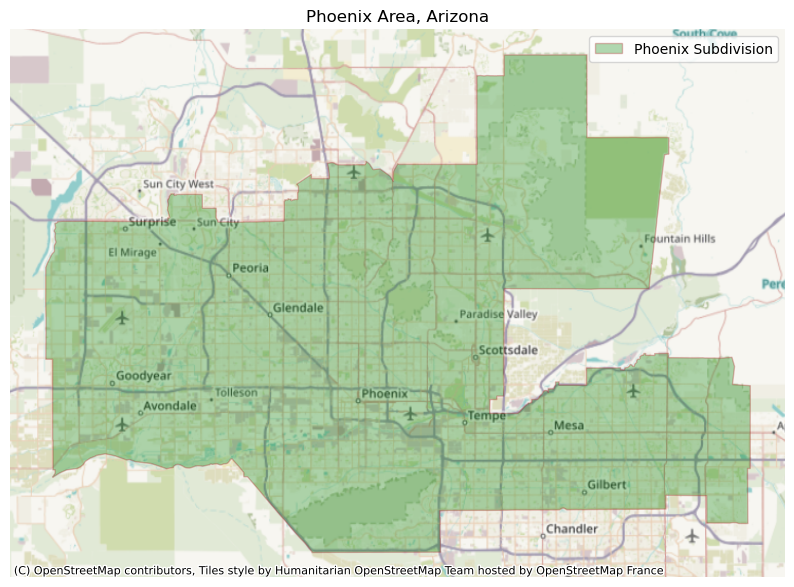

In [19]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Remove axis for cleaner plot
ax.axis("off")

# Create a patch for the legend
from matplotlib.patches import Patch
legend_patch = Patch(facecolor='green', edgecolor='firebrick', alpha=0.3, label='Phoenix Subdivision')

# Plot Phoenix subdivision with label
phoenix.plot(ax=ax, 
            color="green",
            edgecolor="firebrick",
            alpha=0.3,
            label="Phoenix Subdivision"
           )

# Add basemap
ctx.add_basemap(ax, crs='epsg:4326')

plt.subplots_adjust(bottom=0.05)
ax.set_title("Phoenix Area, Arizona")

# Add legend
ax.legend(handles=[legend_patch])

plt.show()

## Obtain the BII Time Series data through a catalog search from the MPC STAC catalog

We will use the 2017 and 2020 rasters covering the Phoenix subdivision. For the bounding box, use the following coordinates:

`[-112.826843, 32.974108, -111.184387, 33.863574]`

In [78]:
# Temporal range of interest during growth of development
time_range = "2017-01-01/2021-01-01"

# Create bounding box for search
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

In [79]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog
search = catalog.search(collections=["io-biodiversity"], bbox=bbox, datetime=time_range)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


The 2017 and 2020 features are the last and first items in the search, respectively.

In [80]:
# Get the 2017 and 2020 BII items
item_2017 = items[3]
item_2020 = items[0]

In [81]:
# Access raster data from item
io_bio2017 = rioxr.open_rasterio(item_2017.assets["data"].href)
io_bio2020 = rioxr.open_rasterio(item_2020.assets["data"].href)

In [82]:
# The the data to the Phoenix subdivision geometry obtained earlier and drop the `band` dimension
io_bio2017 = io_bio2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
io_bio2017 = io_bio2017.squeeze().drop_vars("band")

io_bio2020 = io_bio2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
io_bio2020 = io_bio2020.squeeze().drop_vars("band")


## Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 & 2020

In [83]:
# Find the minimum and maximum values of BII for 2017 and 2020
print("2017 Min value:", io_bio2017.min().values)
print("2017 Max value:", io_bio2017.max().values)
print("2020 Min value:", io_bio2020.min().values)
print("2020 Max value:", io_bio2020.max().values)

# Check that there are the same number of valid pixels for both arrays
assert io_bio2017.count().values == io_bio2020.count().values

2017 Min value: 0.07058962
2017 Max value: 0.8802183
2020 Min value: 0.08015034
2020 Max value: 0.8802183


Create a boolean mask of values where True indicates BII values greater than or equal to 0.75. Then, divide by the total number of pixels and multiply by 100 to obtain the percentage of area.

In [84]:
high_bii_2020 = io_bio2020 >= 0.75
percentage_2020 = (high_bii_2020.sum() / io_bio2020.count()) * 100

high_bii_2017 = io_bio2017 >= 0.75
percentage_2017 = (high_bii_2017.sum() / io_bio2017.count()) * 100

print(
    f"2017 Percentage of area of the Phoenix subdivision with BII >= 0.75: {percentage_2017.values:.2f}%"
)
print(
    f"2020 Percentage of area of the Phoenix subdivision with BII >= 0.75: {percentage_2020.values:.2f}%"
)

2017 Percentage of area of the Phoenix subdivision with BII >= 0.75: 7.13%
2020 Percentage of area of the Phoenix subdivision with BII >= 0.75: 6.49%


In [85]:
type(high_bii_2017)

xarray.core.dataarray.DataArray

The result is an an `xarray.DataArray`. To find the areas where BII was high in 2017 but not in 2020, we can perform a bitwise XOR operation, using `^`. 

In [86]:
# Perform the logical exclusive `XOR` operation on the 2017 and 2020 high BII xarrays
# The result will return a 1 if the values are different and 0 if the values are the same
lost_bii = high_bii_2017 ^ high_bii_2020

In [87]:
# Set 0 values to NA and all other values to 1 using `xr.where`
lost_bii = xr.where(lost_bii, 1, np.nan)
lost_bii

<xarray.DataArray (y: 583, x: 990)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0

## Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020

Text(0.5, 1.0, 'Biodiversity Intactness Index (BII) \nPhoenix Subdivision')

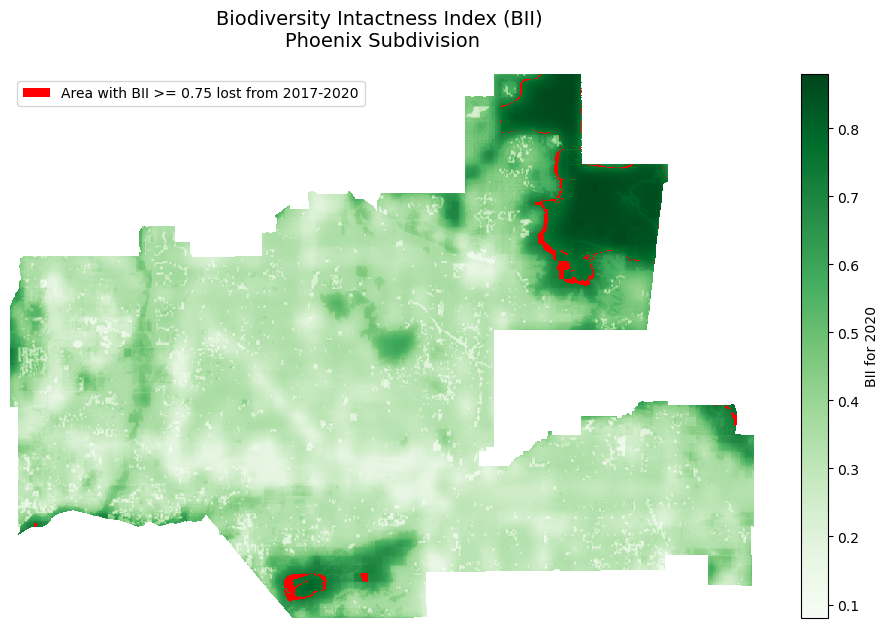

In [88]:
# Set aspect ratio and figure size
aspect = io_bio2020.rio.width / io_bio2020.rio.height
fig, ax = plt.subplots(figsize=(12, 12 / aspect))

# Plot BII in 2020
io_bio2020.plot(
    ax=ax,
    cmap="Greens",
    add_labels=False,
    add_colorbar=True,
    cbar_kwargs={
        "label": "BII for 2020",
    },
)

# Plot the areas experiencing BII loss
lost_bii.plot(
    ax=ax,
    cmap=plt.cm.colors.ListedColormap(["red"]),
    add_labels=False,
    add_colorbar=False,
)

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="red", label="Area with BII >= 0.75 lost from 2017-2020")
]
ax.legend(handles=legend_elements, loc="upper left")

# Remove axis for cleaner plot
ax.axis("off")

# Add title
plt.title("Biodiversity Intactness Index (BII) \nPhoenix Subdivision", pad=20, size=14)

This map shows the Biodiversity Intactness Index (BII) for Phoenix, AZ in 2020. The red represents areas where BII was formerly measured at 0.75 or greater in 2017 but fell below that threshold in 2020. In 2017, 7.13% of the Phoenix subdivision had a BII of 0.75 or greater. This decreased to 6.49% in 2020. This analysis displays how rapid development has decreased biodiversity in the Phoenix area.